# Shikaku

- Divide the grid along the grid lines in rectangles.
- Each rectangle must contain exactly one cell with a number. This number indicates the size of the rectangle; i.e. the number of cells covered by the rectangle.

-----

- 沿网格线将棋盘划分为矩形的小网格；
- 每个矩形必须只包含一个带数字的单元格。此数字表示矩形的大小;即矩形覆盖的单元格数。

![](https://www.janko.at/Raetsel/Sikaku/Regeln-01.gif) ![](https://www.janko.at/Raetsel/Sikaku/Regeln-02.gif)

> Link: https://www.janko.at/Raetsel/Sikaku/index.htm

In [2]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as grb
import numpy as np
import os
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle

In [3]:
def readInstance(path):
    
    # 从测试案例中随机选取一个测试案例出来
    # file_name = f"../assets/data/slitherlinkdata/{path}{np.random.randint(1)+1}.txt"
    file_name = f"../assets/data/Shikaku/problems/{path}.txt"

    m = 0
    n = 0
    grids = None
    print( f"READING FILE {file_name}" )
    if not os.path.isfile(file_name):
        print('File does not exist')
    else:

        with open(file_name) as file:
            firstline = file.readline().strip().split(" ")
            m = int(firstline[0])
            n = int(firstline[1])
            grids = [[0 for _ in range(n)] for _ in range(m)]

            for idx in range(m):
                line = file.readline().strip().split(" ")
                assert len(line) == n
                
                for j in range(n):
                    if line[j] not in [ '.', '-']:
                        grids[idx][j] = int(line[j])
    return m, n, grids

if __name__ == "__main__":
    # data = "30x25normal1"
    data = "220_17x17"
    m, n, grids = readInstance(data)
    # print(grids)
    for g in grids:
        print(g)

READING FILE ../assets/data/Shikaku/problems/220_17x17.txt
[0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0]
[0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 9, 0]
[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0]
[0, 0, 4, 0, 0, 0, 0, 4, 0, 8, 0, 0, 0, 0, 4, 0, 0]
[8, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 8, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0]
[0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0]
[0, 0, 0, 0, 0, 8, 0, 0, 9, 0, 0, 6, 0, 0, 0, 0, 0]
[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0]
[0, 6, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 6, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0]
[5, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4]
[0, 0, 6, 0, 0, 0, 0, 5, 0, 9, 0, 0, 0, 0, 6, 0, 0]
[0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0]
[0, 6, 0, 0, 0, 0, 9, 0, 0, 0, 7, 0, 0, 0, 0, 8, 0]
[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0]


$x[i, j, k]$: 属于方格  [i, j] 内的第 k 种摆放

思路如下：针对每一个包含数字的格，输出所有可行的摆放位置。

想象成在一个格子里放入不同的变量

-> 子问题：怎么获取一个数字对应的所有可能的Shikaku？



In [5]:
from ortools.sat.python import cp_model as cp

def getXY(target):
    if target == 1:
        return [(1,1)]
    else:
        result = []
        for i in range(1, int(math.sqrt(target)) + 1):
            if target % i == 0:
                result.append((i, target // i))
                if i < target // i:
                    result.append((target // i, i))
        return result
    

def get_all_pos(i, j, rect, matrix):
    x_min, x_max = i - rect[0] + 1, i
    y_min, y_max = j - rect[1] + 1, j
    tmp_pos =  [(x, y) for x in range(x_min, x_max + 1) for y in range(y_min, y_max + 1)]
    new_pos = []
    for (x_, y_) in tmp_pos:
        if x_ < 0 or y_ < 0:
            continue
        # 对于位置可行的地方
        matrix_np = np.array(matrix)
        # 提取子矩阵并求和
        submatrix_sum = np.sum(matrix_np[x_: x_ + rect[0] , y_: y_ + rect[1]])
        if submatrix_sum != matrix[i][j] or x_ + rect[0] > len(matrix) or y_ + rect[1] > len(matrix[1]):
            continue
        new_pos.append((x_, y_))
    return new_pos

def Shikaku_solver(m, n, grids):
    model = cp.CpModel()
    solver = cp.CpSolver()
    cells = dict()
    x = dict()
    for i in range(len(grids)):
        for j in range(len(grids[0])):
            cells[i, j] = []
    for i in range(len(grids)):
        for j in range(len(grids[0])):
            
            if grids[i][j] != 0:
                all_fes_pos = []
                tmp_fes_pos = getXY(grids[i][j])
                for (x_, y_) in tmp_fes_pos:
                    tmp_res = get_all_pos(i, j, (x_, y_), grids)
                    if len(tmp_res) > 0:
                        for (sub_x, sub_y) in tmp_res:
                            all_fes_pos.append([sub_x, sub_y, x_, y_])

                for pos in all_fes_pos:

                    a, b, c, d = pos[0], pos[1], pos[2], pos[3]
                    x[a, b, c, d] = model.NewBoolVar(f"x_{a}_{b}_{c}_{d}")

                    for k1 in range(c):
                        for k2 in range(d):

                            cells[a + k1, b + k2].append(x[a, b, c,d])

                model.Add(sum([x[a[0], a[1], a[2], a[3]] for a in all_fes_pos]) == 1)


    for i in range(len(grids)):
        for j in range(len(grids[0])):
            model.Add(sum(cells[i, j]) == 1)
    status = solver.Solve(model)
    result = []
    if status == cp.OPTIMAL:
        print("FOUND OPTIMAL")
        for k, v in x.items():
            if solver.Value(x[k]) == 1:
                result.append(list(k))
    return result
    
if __name__ == "__main__":
    data = "220_17x17"
    m, n, grids = readInstance(data)
    result = Shikaku_solver(m, n, grids)
    # print(result)


READING FILE ../assets/data/Shikaku/problems/220_17x17.txt
FOUND OPTIMAL


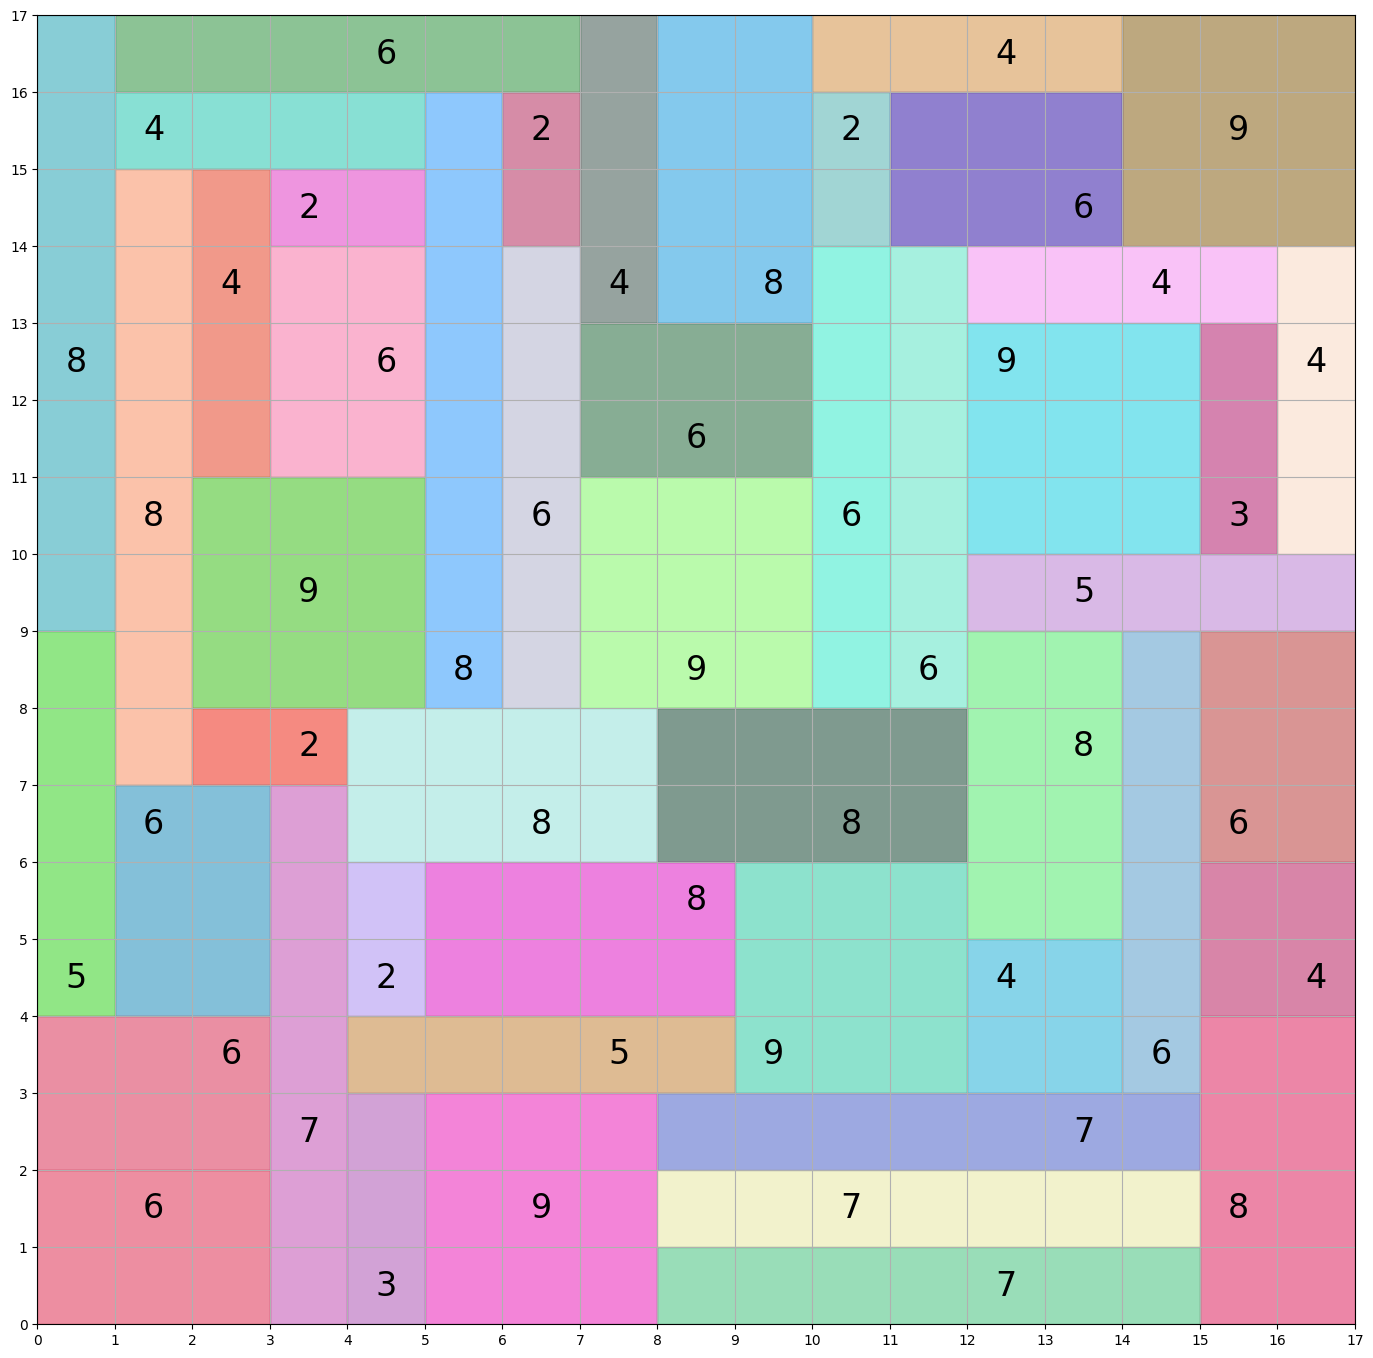

In [6]:
def generate_random_color():
    # 生成三个随机的十六进制数字，每个数字的范围是0-255
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    
    # 将RGB值转换为十六进制字符串
    hex_color = f'#{r:02x}{g:02x}{b:02x}'
    return hex_color

def coordinatesParser(m, n, idx):
    """_summary_
        进行坐标转换 
    Args:
        m (_type_): _description_
        n (_type_): _description_
        idx (_type_): _description_

    Returns:
        _type_: _description_
    """
    ori_x , ori_y = idx // n, idx % n 
    return (0.5 + ori_y, 0.5 + ( m - ori_x - 1) )

def coordinatesParserNodes(m, n, idx):
    ori_x, ori_y = idx // (n + 1), idx % (n + 1)
    return (ori_y, m - ori_x )


def vis(m, n, grids, result):
    # 可视化
    random.seed(123)
    grid_color = dict()
    for idx, _ in enumerate(result):
        grid_color[f"{idx}"] = generate_random_color()
    plt.figure(figsize = (n, m))
    ax = plt.gca()
    x_major_locator = MultipleLocator(1)
    y_major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    # 把x/y轴的主刻度设置为1的倍数
    ax.yaxis.set_major_locator(y_major_locator)
    plt.xlim(0,n)
    plt.ylim(0,m)
    for i in range(m):
        for j in range(n):
            if grids[i][j] != 0:
                new_coor = coordinatesParser(m, n, i * n + j)
                ax.text(new_coor[0], new_coor[1], str(grids[i][j]), 
                        horizontalalignment = "center", 
                        verticalalignment = 'center',
                        fontsize = 24)
    for idx, rect in enumerate(result):
        # [0, 0, 1, 3]
        i, j = rect[0] + rect[2] - 1, rect[1] 
        ax.add_patch(Rectangle((j, m - i - 1), rect[3], rect[2], color = grid_color[f"{idx}"], alpha = 0.5))
    
    plt.grid(linestyle = "-")
    
    plt.show()

if __name__ == "__main__":
    vis(m, n, grids, result)